# Assignment 2

In [1]:
import h5py
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2

from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split

#Decomposers
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

#Keras Modeling
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Dense, Dropout, MaxPooling2D, Convolution2D, Conv2D, Flatten, GlobalAveragePooling2D,InputLayer
from keras.layers import Activation, ZeroPadding2D, LeakyReLU, BatchNormalization


from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
import skimage
from skimage import morphology
from skimage import measure
from skimage import io

!pip install mahotas
import mahotas

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 1
## A

In [3]:
D = h5py.File('drive/My Drive/breast.h5', 'r')
X,Y,P = D['images'],np.array(D['counts']),np.array(D['id'])

X = np.array(X)

train_count = 0
test_count = 0

for i in range(len(P)):
    if P[i] <= 13:
        train_count += 1
    elif P[i] > 13:
        test_count += 1
    else:
        print('Problem')
        
print('Number of training samples :', train_count)
print('Number of testing samples :', test_count)

Number of training samples : 5841
Number of testing samples : 1563


## B

I can see that the target count seams to relate to the number of of brown stained cells in the image.

1


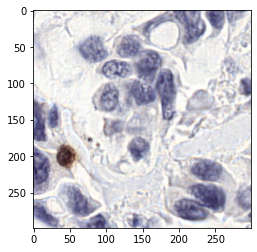

2


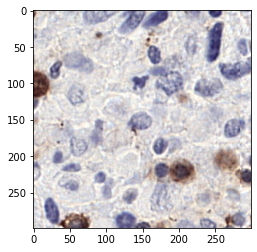

2


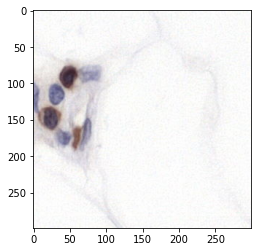

5


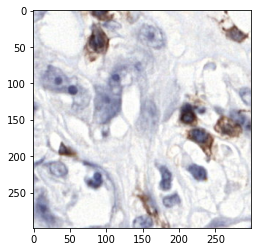

1


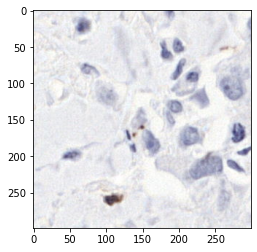

2


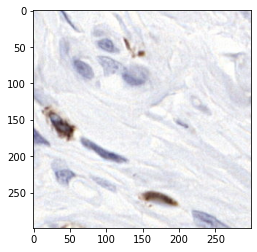

0


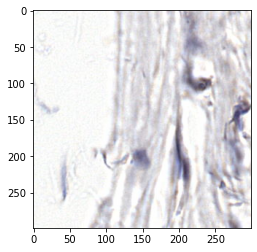

1


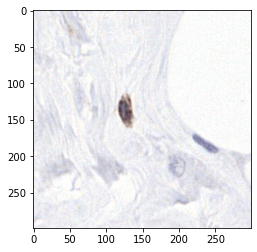

3


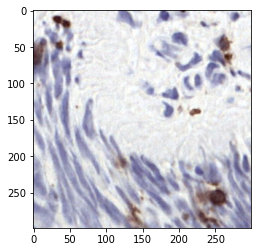

6


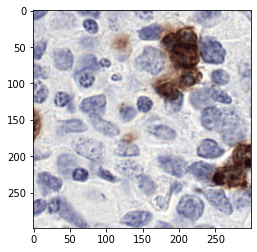

In [26]:
for i in range(10):
    
    ran = int(random.random()*len(X))
    
    print(Y[ran])
    plt.imshow(X[ran])
    plt.show()

## C

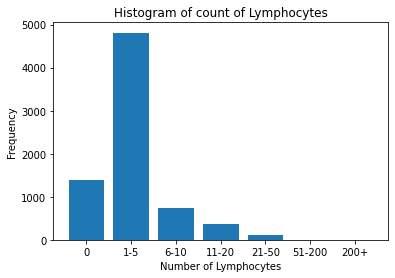

In [27]:
a=0
b=0
c=0
d=0
e=0
f=0
g=0

for i in range(len(Y)):
    if Y[i] == 0:
        a+=1
    elif 1 <= Y[i] < 6:
        b+=1
    elif 6 <= Y[i] < 11:
        c+=1
    elif 11 <= Y[i] < 21:
        d+=1
    elif 21 <= Y[i] < 51:
        e+=1
    elif 51 <= Y[i] < 200:
        f+=1
    else:
        g+=1

label = ['0', '1-5', '6-10', '11-20', '21-50', '51-200', '200+']
Q=[a, b, c, d, e, f, g]

plt.bar(label,Q)
plt.xlabel('Number of Lymphocytes')
plt.ylabel('Frequency')
plt.title('Histogram of count of Lymphocytes')
plt.show()

## D

For this part of the assignment I have dissplayed the image of a random image and then the image converted to HED space.

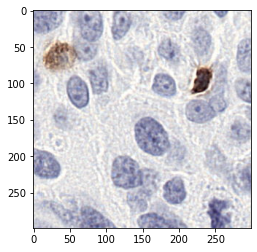

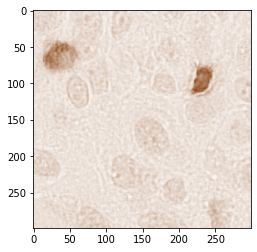

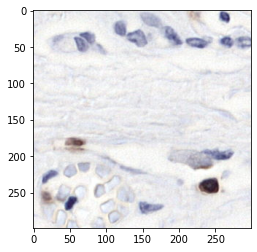

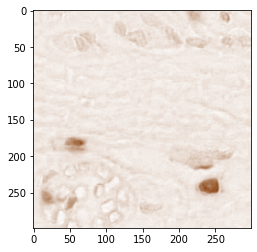

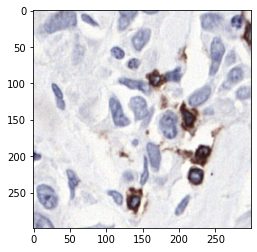

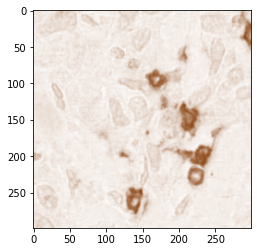

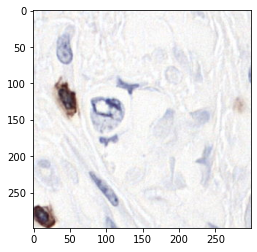

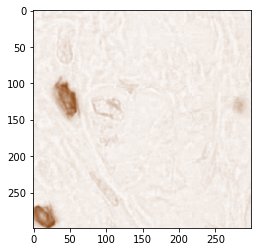

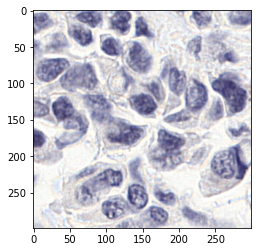

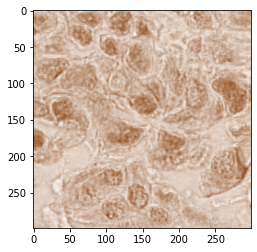

In [28]:

# Create an artificial color close to the original one
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])

for i in range(5):
    rand = int(random.random()*4500)
    ihc_rgb = X[rand]
    plt.imshow(ihc_rgb)
    plt.show()
    ihc_hed = rgb2hed(ihc_rgb)
    plt.imshow(ihc_hed[:, :, 2], cmap=cmap_dab)
    plt.show()


## E

As can be seen in the plot below there is a correlation between the mean of the brown channel and thenumber of Lymphocytes. This means that it can be used as a and would offer some benifits for use in a regression model, however the Lymphocytes count of zero ranges a lot so may cause some issues. On the whole though I would use this feature, possibly extracting the mean of each individual colour channel may give better performance.

<class 'numpy.ndarray'>


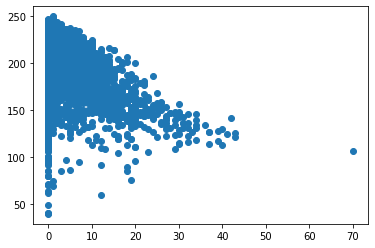

In [29]:
print(type(X))
scat = []
for im in X:
    mean = np.mean(im)
    scat.append(mean)

plt.scatter(Y[:len(scat)],scat)

This may be a good feature for the regresion models as there is a clear negative correlation between the average of the brown channel and the number of cells.

## F

The number of images for each patient will have an impact on the regression models as it is entirely possible that individual patients have slight variations in the general image this would then cause overfitting towards the patients that have the most images.

In [30]:

for patient in range(1,19):
    a = 0
    for id_ in P:
        if id_ == patient:
            a += 1
    print('Patient', patient, ', number of images',a)
            

Patient 1 , number of images 320
Patient 2 , number of images 465
Patient 3 , number of images 958
Patient 4 , number of images 192
Patient 5 , number of images 44
Patient 6 , number of images 105
Patient 7 , number of images 83
Patient 8 , number of images 632
Patient 9 , number of images 533
Patient 10 , number of images 552
Patient 11 , number of images 761
Patient 12 , number of images 791
Patient 13 , number of images 405
Patient 14 , number of images 105
Patient 15 , number of images 399
Patient 16 , number of images 604
Patient 17 , number of images 103
Patient 18 , number of images 352


## G

Some metrics that can be used are mean absolute error that takes the differance between the predicted and actual value, rooted mean squared error. The MAE is not the best metric as small errors are to be expected and aren't as important as large errors in this task.

The best metric for this task will be rooted mean squared error RMSE, this is because the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable. 

## Task 2 
## A

In this question I have started by extracting all the features that I use. These are the mean of each channel, the variance of each channel, the entropy of each channel, a histogram of each channel the PCA singular values of each channel and image moments of each image. 

The mean and variance probably wont be good features to use as they are very general parts of the image.

Entropy is an important feature as it relates the intencity of the image in places, this is useful as the places where target cells are are stained and thus have a higher intencity.

The histogram is taken with 5 points on the graph as this reduces some of the redundencies in using all 256 potential pixel intencities. When looking at the histograms I observed some patterns between the target number and the plots so I think that these will be a good factor to use.

I have taken the first 30 singular values this is because in testing the network and models I found that these produced results with the best RMSE, and this number of singular values explained a large amount of the variance. This means that the PCA will be a good and important feature.

I have also chosen to use two different image moments features these being Hu moments and Haralick features. Hu moments are useful as if two shapes are the same in an image, the image moment will necessarily be the same for those images. This is useful as it can be used to see how similar two images are, and hence is a good factor in prediction. Haralick features generate 14 statistical features based on the texture of an image, these have been shown to be useful in the problems similar to this one. These properties of the image moments make them important factors in this task.

In [4]:
from scipy.stats import entropy

brown = []
for im in X:
  brown.append(rgb2hed(im))


print('mean')
#This calculates the mean of each of the channels
mean = []
a=0
for im in X:
  m = []
  for i in range(3):
    line = im[:,:,i]
    m.append(np.mean(line))
  m.append(np.mean(brown[a][:, :, 2]))
  a+=1
  mean.append(m)

print('entropy')
#This calculates the entropy of each of the channels
entro = []
a=0
for im in X:
  m = []
  for i in range(3):
    line = im[:,:,i]
    m.append(entropy(line.ravel()))
  m.append(entropy(brown[a][:, :, 2].ravel()))
  a+=1
  entro.append(m)

print('variance')
#This calculates the variance of each of the channels
var = []
a=0
for im in X:
  m = []
  for i in range(3):
    line = im[:,:,i]
    m.append(np.std(line)**2)
  m.append(np.std(brown[a][:, :, 2])**2)
  a+=1
  var.append(m)

print('histogram')
#This calculates the histogram of each of the channels
his = []
for im in X:
    h=[]
    color = ('b','g','r')
    for i,col in enumerate(color):
        hist = cv2.calcHist(im,[i],None,[5],[0,256])
        #plt.plot(hist,color = col)
        cv2.normalize(hist, hist)
        h.append(hist.ravel())
    his.append(h)
    #plt.show()

print('PCA')
#This calculates the singular values using the PCA of each of the channels

from sklearn.decomposition import PCA

pca = PCA(n_components=30,svd_solver='randomized')

Pca = []
for im in X:
  m = []
  for i in range(3):
    pca.fit_transform(im[:,:,i])
    m.append(pca.singular_values_)
  Pca.append(m)

#These functions calculate the image momnets of a gray scale image
def fd_hu_moments(image):
    #Computes the Hu moments 
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature


def fd_haralick(image):
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(image).mean(axis=0)
    return haralick

print('Moments')

moments = []
for im in X:
  m=[]
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  m.append(fd_hu_moments(im))
  m.append(fd_haralick(im))
  moments.append(m)


mean
entropy
variance
histogram
PCA
Moments


Below are plots showing a scatter of the some of the extracted features against the number of lymphocytes, with the correlation between the two shown below.

As can be seen the mean of each channel is negativly correlated with the number of lymphocytes, although there is a large spread of the data.
That is except the brown channel that is positivly correlated and is also more strongly correlated.

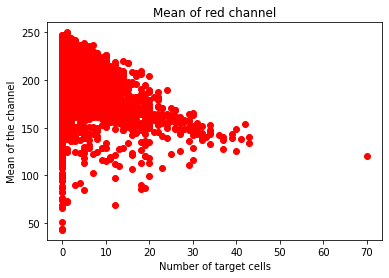

Correlation : -0.41697597789967517


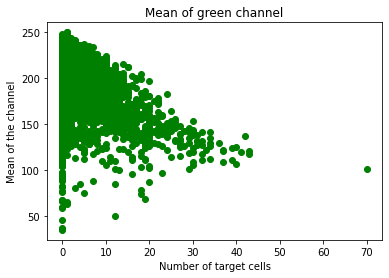

Correlation : -0.4785895917683095


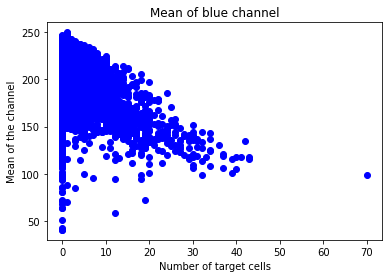

Correlation : -0.5387397493715256


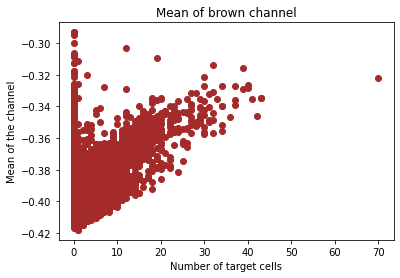

Correlation : 0.5925905331304643


In [5]:
from scipy.stats import pearsonr
r = []
for i in mean:
  r.append(i[0])
plt.scatter(Y,r, color='red')
plt.ylabel('Mean of the channel')
plt.xlabel('Number of target cells')
plt.title('Mean of red channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


r = []
for i in mean:
  r.append(i[1])
plt.scatter(Y,r, color='green')
plt.ylabel('Mean of the channel')
plt.xlabel('Number of target cells')
plt.title('Mean of green channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


r = []
for i in mean:
  r.append(i[2])
plt.scatter(Y,r,color='blue')
plt.ylabel('Mean of the channel')
plt.xlabel('Number of target cells')
plt.title('Mean of blue channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)

r = []
for i in mean:
  r.append(i[3])
plt.scatter(Y,r, color='brown')
plt.ylabel('Mean of the channel')
plt.xlabel('Number of target cells')
plt.title('Mean of brown channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


As can be seen the variance of each channel is possitivly correlated with the number of lymphocytes, although there is again a large spread of the data but not as extreem as in the mean. Again the brown channel shows the most correlation.

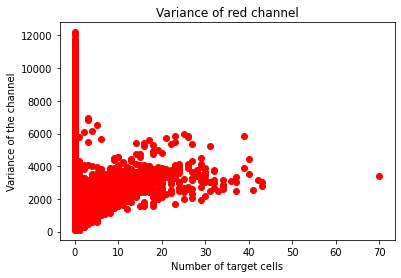

Correlation : 0.15261987421658352


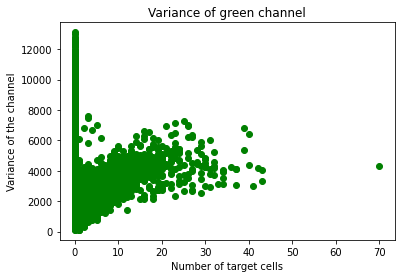

Correlation : 0.2425585361249029


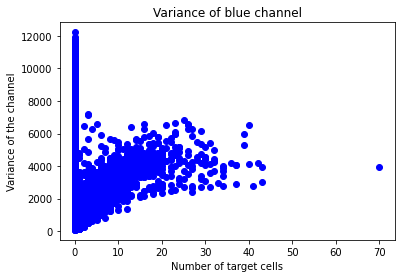

Correlation : 0.3098443918501181


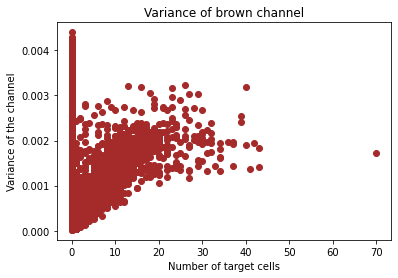

Correlation : 0.43721117127566955


In [6]:
r = []
for i in var:
  r.append(i[0])
plt.scatter(Y,r, color='red')
plt.ylabel('Variance of the channel')
plt.xlabel('Number of target cells')
plt.title('Variance of red channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


r = []
for i in var:
  r.append(i[1])
plt.scatter(Y,r, color='green')
plt.ylabel('Variance of the channel')
plt.xlabel('Number of target cells')
plt.title('Variance of green channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


r = []
for i in var:
  r.append(i[2])
plt.scatter(Y,r,color='blue')
plt.ylabel('Variance of the channel')
plt.xlabel('Number of target cells')
plt.title('Variance of blue channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)

r = []
for i in var:
  r.append(i[3])
plt.scatter(Y,r,color='brown')
plt.ylabel('Variance of the channel')
plt.xlabel('Number of target cells')
plt.title('Variance of brown channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


As can be seen the entropy of each channel is slightly negativly correlated with the number of lymphocytes, although the spread of the data is alot less than in the previous two features. Again the brown channel is more strongly correlated.

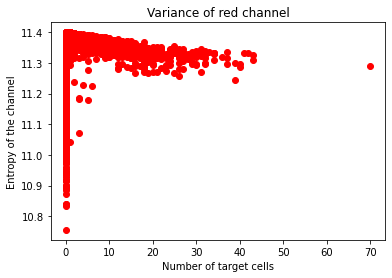

Correlation : -0.11484737081801791


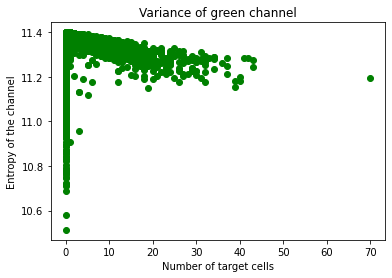

Correlation : -0.22128643404227394


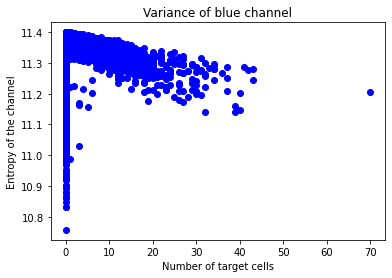

Correlation : -0.29378556832323666


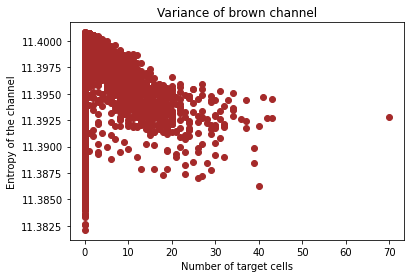

Correlation : -0.4506390415939179


In [7]:
r = []
for i in entro:
  r.append(i[0])
plt.scatter(Y,r, color='red')
plt.ylabel('Entropy of the channel')
plt.xlabel('Number of target cells')
plt.title('Variance of red channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


r = []
for i in entro:
  r.append(i[1])
plt.scatter(Y,r, color='green')
plt.ylabel('Entropy of the channel')
plt.xlabel('Number of target cells')
plt.title('Variance of green channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


r = []
for i in entro:
  r.append(i[2])
plt.scatter(Y,r,color='blue')
plt.ylabel('Entropy of the channel')
plt.xlabel('Number of target cells')
plt.title('Variance of blue channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)


r = []
for i in entro:
  r.append(i[3])
plt.scatter(Y,r,color='brown')
plt.ylabel('Entropy of the channel')
plt.xlabel('Number of target cells')
plt.title('Variance of brown channel')
plt.show()

corr, _ = pearsonr(r,Y)
print('Correlation :', corr)

## B

In [8]:
#General checks on the data
print(type(var),len(var))
print(type(mean),len(mean))
print(type(Pca),len(Pca))
print(type(moments),len(moments))
print(type(entro),len(entro))
print(type(his),len(his))

<class 'list'> 7404
<class 'list'> 7404
<class 'list'> 7404
<class 'list'> 7404
<class 'list'> 7404
<class 'list'> 7404


I first start expermenting with factors by using all the factors to predict a bench mark level to compare using different combinations of factors to. 

When expermenting to see which factors are the best I found that using just one of the factors decreases the performance over all of the models, however using just entropy in the OLS model was slightly better. Except 

Using the best two predictors those being entropy and image moments there is a 0.4 decrease in the RMSE of the OLS and ridged model however the SVR with these factors, the RMSE increases by 0.6.

The model seems to perfrom best when the mean and variance of each channel aren't used, so the models from this point on will only use the data without the mean and variance.

In [0]:
#This code combines all the feature data for each image as a single array for each feature.

Xt = []
for i in range(len(his)):

  #m = mean[i] + var[i] + list(np.concatenate(Pca[i])) + list(entro[i]) + list(np.concatenate(his[i])) + list(np.concatenate(moments[i]))
  m= list(entro[i]) + list(np.concatenate(moments[i])) + list(np.concatenate(Pca[i])) + list(np.concatenate(his[i])) 

  Xt.append(np.array(m))

In [0]:
#This code splits the data into training and testing data

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold


X_train = Xt[:5841]
X_test = Xt[5841:]

y_train = Y[:5841]
y_test = Y[5841:]


The code below trains and tests a Ordinary Least Squares (OLS) regression model. Fine tuning the hyper-parameters I can acchive a RMSE of 3.09, making it the second best model only beaten by the CNN in part 3.

In [11]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=10)

kf = KFold(n_splits=3)
scores = cross_val_score(reg, X_train, y_train, cv=kf)

print('Cross-validation score :', scores.mean())
reg.fit(X_train,y_train)
pred = reg.predict(X_test)

Cross-validation score : 0.48964439539568044


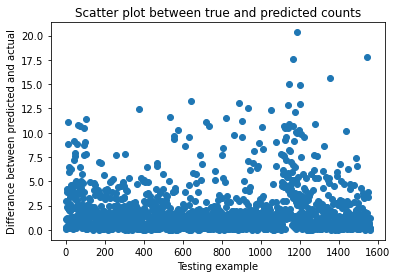

R2 :  0.6349211700429793
corr :  0.8290610467167177
RSME :  3.0953172489754435


In [12]:
s=[]
for i in range(len(pred)):
  s.append(abs(y_test[i]-pred[i]))
plt.scatter(range(len(pred)),s)
plt.ylabel('Differance between predicted and actual')
plt.xlabel('Testing example')
plt.title('Scatter plot between true and predicted counts')
plt.ylim()
plt.show()

from sklearn.metrics import r2_score
print('R2 : ', r2_score(y_test, pred))

from scipy.stats import pearsonr

y=[]
yp=[]
for i in range(len(pred)):
  y.append(float(y_test[i]))
  yp.append(pred[i])
corr, pval = pearsonr(y,yp)
print('corr : ', corr)

from sklearn.metrics import mean_squared_error
print('RSME : ', np.sqrt(mean_squared_error(y_test,pred)))



The code below is a Multilayer Perceptron model, this is the worse performing model with a RMSE is 4.38.

In [13]:
import keras

model = keras.models.Sequential()

model.add(Dense(64, input_dim=len(X_train[0]), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(1024))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dense(1, activation='relu')) # set activation='relu' to keep all values positive

model.summary()

model.compile(Adam(lr=0.001), loss='mean_squared_error', 
              metrics=['mse'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_

In [14]:

#model.fit(np.array(X_train), y_train, validation_split=0.25, batch_size=128, epochs=120, shuffle=True)
#model.save('multi.h5')
from keras.models import load_model
model = load_model('drive/My Drive/multiP.h5')
pred = model.predict(np.array(X_test))

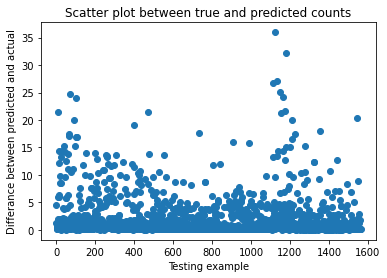

R2 :  0.26983566175296114
corr :  0.7440445785752903
RSME :  4.377459652266491


In [15]:
s=[]
for i in range(len(pred)):
  s.append(abs(y_test[i]-pred[i]))
plt.scatter(range(len(pred)),s)
plt.ylabel('Differance between predicted and actual')
plt.xlabel('Testing example')
plt.title('Scatter plot between true and predicted counts')
plt.ylim()
plt.show()

from sklearn.metrics import r2_score
print('R2 : ', r2_score(y_test, pred))

from scipy.stats import pearsonr

y=[]
yp=[]
for i in range(len(pred)):
  y.append(float(y_test[i]))
  yp.append(pred[i][0])
corr, pval = pearsonr(y,yp)
print('corr : ', corr)


from sklearn.metrics import mean_squared_error
print('RSME : ', np.sqrt(mean_squared_error(y_test,pred)))



The model below is Ridge Regression model, this is one of the worst performing models with a RMSE of 3.31.

In [16]:
from sklearn.linear_model import Ridge
import numpy as np

clf = Ridge(alpha=2.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

kf = KFold(n_splits=3)
scores = cross_val_score(clf, X_train, y_train, cv=kf)

print('Cross validation score :', scores.mean())
clf.fit(X_train, y_train)

pred = clf.predict(X_test)


Cross validation score : 0.5370219151548963


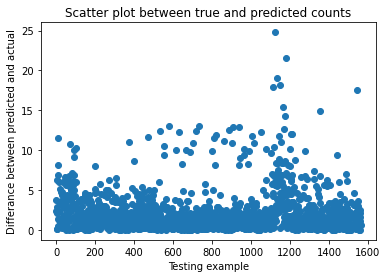

R2 :  0.5820589939035665
corr :  0.7712790996275544
RSME :  3.3118399054514325


In [17]:
s=[]
for i in range(len(pred)):
  s.append(abs(y_test[i]-pred[i]))
plt.scatter(range(len(pred)),s)
plt.ylabel('Differance between predicted and actual')
plt.xlabel('Testing example')
plt.title('Scatter plot between true and predicted counts')
plt.ylim()
plt.show()

from sklearn.metrics import r2_score
print('R2 : ', r2_score(y_test, pred))

from scipy.stats import pearsonr

y=[]
yp=[]
for i in range(len(pred)):
  y.append(float(y_test[i]))
  yp.append(pred[i])
corr, pval = pearsonr(y,yp)
print('corr : ', corr)


from sklearn.metrics import mean_squared_error
print('RSME : ', np.sqrt(mean_squared_error(y_test,pred)))



Finally, below is the SVR model this model is the third best model only being beaten by the CNN and OLS, its RMSE is 3.13.

In [18]:
from sklearn.svm import SVR

clf = SVR(kernel='rbf', degree=5, gamma='scale', coef0=0.10, tol=0.001, C=15.0, epsilon=0.1, 
          shrinking=True, cache_size=200, verbose=False, max_iter=-1)

kf = KFold(n_splits=3)
scores = cross_val_score(clf, X_train, y_train, cv=kf)

print('Cross-validation score :', scores.mean())
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

Cross-validation score : 0.5963803431381752


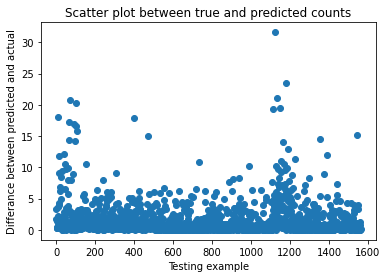

R2 :  0.6258688955490844
corr :  0.7941462837727576
RSME :  3.1334570834328472


In [19]:
s=[]
for i in range(len(pred)):
  s.append(abs(y_test[i]-pred[i]))
plt.scatter(range(len(pred)),s)
plt.ylim()
plt.ylabel('Differance between predicted and actual')
plt.xlabel('Testing example')
plt.title('Scatter plot between true and predicted counts')
plt.show()

from sklearn.metrics import r2_score
print('R2 : ', r2_score(y_test, pred))

from scipy.stats import pearsonr

y=[]
yp=[]
for i in range(len(pred)):
  y.append(float(y_test[i]))
  yp.append(pred[i])
corr, pval = pearsonr(y,yp)
print('corr : ', corr)


from sklearn.metrics import mean_squared_error
print('RSME : ', np.sqrt(mean_squared_error(y_test,pred)))



## Task 3

In this task I have built a CNN that takes in the an image directly as an input, and produces a count as an output. This is my best performing model with a RMSE of 2 and is highly correlated with the actual value (0.92) and a r2 score of 0.83.

In [0]:
from keras.layers import AveragePooling2D, BatchNormalization

In [21]:
#The CNN model
kernel_size = (5,5) 
pool_size= (2,2) 
first_filters = 16
second_filters = 32
third_filters = 64

dropout_conv = 0.32
dropout_dense = 0.3


model = Sequential()

model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (299,299,3)))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
model.add(AveragePooling2D(pool_size = pool_size)) 
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
model.add(AveragePooling2D(pool_size = pool_size)) 
#model.add(Conv2D(third_filters, kernel_size, activation = 'relu'))
#model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))


model.add(Flatten())

model.add(Dense(1024))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dense(1, activation='relu')) # set activation='relu' to keep all values positive

model.summary()

model.compile(Adam(lr=0.001), loss='mean_squared_error', 
              metrics=['mse'])



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 295, 295, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 147, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 143, 143, 16)      6416      
_________________________________________________________________
dropout_5 (Dropout)          (None, 143, 143, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 139, 139, 32)      12832     
_________________________________________________________________
average_pooling2d_1 (Average (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 65, 65, 16)     

In [0]:
#Trining/loading of the pretrained model

#history = model.fit(X[:5841],Y[:5841], validation_split=0.1, batch_size=16, epochs=120, shuffle=True)
from keras.models import load_model
model = load_model('drive/My Drive/new_model1.h5')
#model.save('my_model1.h5')

In [0]:
#Predicting using the model
pred = model.predict(X[5841:])


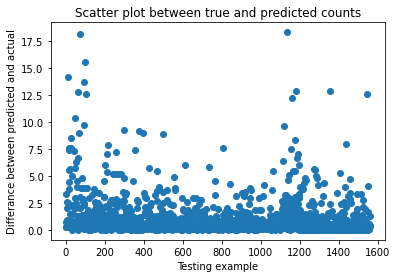

In [24]:
s=[]
for i in range(len(pred)):
  s.append(abs(Y[i+5841]-pred[i]))
plt.scatter(range(len(pred)),s)
plt.ylim()
plt.ylabel('Differance between predicted and actual')
plt.xlabel('Testing example')
plt.title('Scatter plot between true and predicted counts')
plt.show()

In [25]:
from sklearn.metrics import r2_score
print('R2 : ', r2_score(Y[5841:], pred))

from scipy.stats import pearsonr
y=[]
yp=[]
for i in range(len(pred)):
  y.append(float(Y[i+5841]))
  yp.append(pred[i][0])
corr, pval = pearsonr(y,yp)
print('corr : ', corr)

from sklearn.metrics import mean_squared_error
print('RSME : ', np.sqrt(mean_squared_error(Y[5841:],pred)))



R2 :  0.8336195048382244
corr :  0.917193661486864
RSME :  2.0895994683790904
